In [2]:
import os
import sys
import numpy as np
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
from sklearn.utils import shuffle
import pylab
from tensorflow.contrib.layers import flatten

In [3]:
data_path="./MNIST_data"
model_path="./model/"
log_path="./log/"

# 加载MINIST数据集

In [4]:
mnist=input_data.read_data_sets(data_path,reshape=False)
x_train,y_train=mnist.train.images,mnist.train.labels
x_val, y_val = mnist.validation.images, mnist.validation.labels
x_test, y_test = mnist.test.images, mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


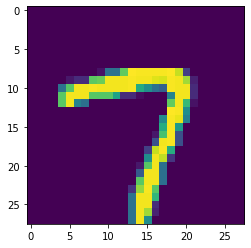

In [5]:
im=mnist.train.images[3364]
im=im.reshape(-1,28)
pylab.imshow(im)

In [6]:
tf.summary.image('input', x_test, 5)

<tf.Tensor 'input:0' shape=() dtype=string>

## 图片预处理Padding

In [7]:
x_train = np.pad(x_train, [(0,0),(2,2),(2,2),(0,0)], "constant")
x_val = np.pad(x_val, [(0,0),(2,2),(2,2),(0,0)], "constant")
x_test = np.pad(x_test, [(0,0),(2,2),(2,2),(0,0)], "constant")

# 随机打乱

In [8]:
x_train,y_train=shuffle(x_train,y_train)

In [9]:
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 1))
y = tf.placeholder(tf.int32, shape=(None))

# 独热码

In [10]:
y_onehot=tf.one_hot(y,10)

## LENET

In [11]:
def LeNet(x):
    mu = 0
    sigma = 0.1
    conv1_w = tf.Variable(tf.truncated_normal(shape=[5,5,1,6], mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_w, strides=[1,1,1,1], padding="VALID") + conv1_b
    conv1 = tf.nn.relu(conv1)
    pool_1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1],strides=[1,2,2,1], padding="VALID")

    conv2_w = tf.Variable(tf.truncated_normal(shape=[5,5,6,16], mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides=[1,1,1,1], padding="VALID") + conv2_b

    conv2 = tf.nn.relu(conv2)
    pool_2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1],strides=[1,2,2,1], padding="VALID")

    fc1 = flatten(pool_2)
    fc1_w = tf.Variable(tf.truncated_normal(shape=(400,120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1, fc1_w)+fc1_b
    fc1 = tf.nn.relu(fc1)

    fc2_w = tf.Variable(tf.truncated_normal(shape=(120,84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_w) + fc2_b
    fc2 = tf.nn.relu(fc2)

    fc3_w = tf.Variable(tf.truncated_normal(shape=(84,10), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    
    return logits

## 获取损失函数

In [12]:
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_onehot, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Adam优化器

In [13]:
learning_rate=0.001
optimizer = tf.train.AdamOptimizer(learning_rate)

## 训练模型

In [14]:
def evaluate(x, y, x_data, y_data, Batch_size, acc):
    num_examples = len(x_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for begin in range(0, num_examples, Batch_size):
        batch_x, batch_y = x_data[begin: begin+Batch_size], y_data[begin: begin+Batch_size]
        accuracy = sess.run(acc, feed_dict={x: batch_x, y: batch_y})
        total_accuracy = total_accuracy + (accuracy*len(batch_x))
    return total_accuracy/num_examples

In [15]:
Batch_size=128
Epochs = 10
is_train=True
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_onehot, 1))
acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

tf.summary.scalar('loss',loss_operation)
tf.summary.scalar('accuracy', acc)
summ = tf.summary.merge_all()

saver = tf.train.Saver()

if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(log_path):
    os.mkdir(log_path)



## 训练

In [16]:
with tf.Session() as sess:
    total_batch = int(mnist.train.num_examples/Batch_size)
    writer = tf.summary.FileWriter(log_path)
    writer.add_graph(sess.graph)
    
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)
    print("-------Start Training-------")
    for i in range(Epochs):
        x_train, y_train = shuffle(x_train, y_train)
        for j in range(total_batch):
            begin = j * Batch_size
            end = begin + Batch_size
            # batch_x, batch_y = mnist.train.next_batch(Batch_size)
            batch_x, batch_y = x_train[begin:end], y_train[begin:end]
            _, summ1 = sess.run([training_operation,summ], feed_dict={x:batch_x, y:batch_y})
            # writer.add_summary(summ1, i)
            writer.add_summary(summ1, i * total_batch + j)
        val_acc = evaluate(x, y, x_val, y_val, Batch_size, acc)
        print("Epochs {}".format(i+1))
        print("Validation Accuracy = {:.4f}".format(val_acc))
        saver.save(sess, model_path+"model.ckpt")
    print("model saved")2
    
    writer.close()

-------Start Training-------
Epochs 1
Validation Accuracy = 0.9694
Epochs 2
Validation Accuracy = 0.9792
Epochs 3
Validation Accuracy = 0.9818
Epochs 4
Validation Accuracy = 0.9874
Epochs 5
Validation Accuracy = 0.9876
Epochs 6
Validation Accuracy = 0.9854
Epochs 7
Validation Accuracy = 0.9874
Epochs 8
Validation Accuracy = 0.9892
Epochs 9
Validation Accuracy = 0.9872
Epochs 10
Validation Accuracy = 0.9880
model saved


In [17]:
with tf.Session() as sess:
    total_batch = int(mnist.train.num_examples/Batch_size)
    writer = tf.summary.FileWriter(log_path)
    writer.add_graph(sess.graph)
    
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)
    print("-------Start Testing-------")
    model_file = tf.train.latest_checkpoint(model_path)
    saver.restore(sess,model_file)
    test_acc = sess.run(acc, feed_dict={x: x_test, y: y_test})
    print('test_acc: {:.4f}'.format(test_acc))

-------Start Testing-------
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model/model.ckpt
test_acc: 0.9883
